In [1]:
import numpy as np
import numpy.linalg as la
import scipy as sp
import scipy.integrate as spint
import matplotlib.pyplot as plt

from fluids.atmosphere import ATMOSPHERE_1976 as atm

import rocketPy as rp
from rocketPy import ureg, si, unit_vector, angle_between




Rocket: Simple Rocket

Rocket Details
+--------------------------+---------------+-------------------+
|        Parameter         |     Value     |       Notes       |
+--------------------------+---------------+-------------------+
|        Total Mass        |   2.5308 kg   |                   |
|       Total Length       |   70.0000 in  |                   |
|           X_CG           |   1.240669 m  |                   |
|           X_CP           |    1.3603 m   | At default values |
| Static Margin (calibers) |     0.7848    | At default values |
|            CD            |     0.3391    | At default values |
|           CNa            | 19.1828 / rad | At default values |
+--------------------------+---------------+-------------------+

Component Details
+-----------+------------+------------+---------+-----------------+--------------+
| Component |    Type    |  Material  |   Mass  | Mass Fraction % |     CNa      |
+-----------+------------+------------+---------+-------------

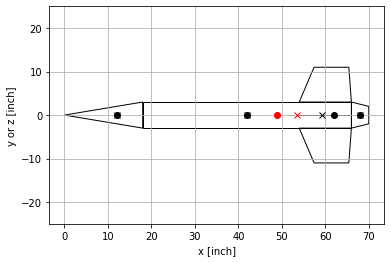

In [2]:
# generate rocket

## First, create a rocket.
r = rp.Rocket(name='Simple Rocket')

## create a nose cone
nc = rp.NoseCone(name='Nose Cone', diameter=6*ureg.inch, fineness=3, material=rp.materials.PLA())
# assign to rocket
r.set_nose_cone(nc)

## create a BodyTube
bt = rp.BodyTube(name = 'Body Tube', diameter=6*ureg.inch, length=48*ureg.inch, wall_thickness=2*ureg.mm, material=rp.materials.Phenolic())
# define its location
bt.set_position(after=nc)
# assign to rocket
r.set_body_tube(bt)

# create a boat tail
boat_tail = rp.Transition(name='Boat Tail', fore_dia=6*ureg.inch, aft_dia=4*ureg.inch, length=4*ureg.inch, material=rp.materials.Phenolic())
# define its location
boat_tail.set_position(after=bt)
# assign to rocket
r.set_boat_tail(boat_tail)

## create the fins
fins = rp.FinSet(name='Fins', n=4, span=8*ureg.inch, root_chord=12*ureg.inch, tip_chord=8*ureg.inch, mid_sweep=10*ureg.degree, tube_dia=6*ureg.inch,  thickness=2*ureg.mm, material=rp.materials.Aluminium())
# define its location
fins.set_position(end_of=bt, offset=-fins.root_chord)
#  assign to rocket
r.set_fins(fins)

# plot the entire rocket
fig = plt.figure()
ax = plt.gca()
r.plot(ax, unit=ureg.inch)
plt.draw()

# describe the rocket
r.describe(describe_components=True)

plt.show()



In [3]:
r.xcp()

1.3602772252343966 <Unit('meter')>

In [4]:
r.xcg()

1.240668712985451 <Unit('meter')>

In [5]:
((r.xcp()-r.xcg())/r.diameter).to_base_units()

0.7848327575390134 <Unit('dimensionless')>

In [6]:
r.static_margin()

0.7848327575390134 <Unit('dimensionless')>

In [7]:
r.CD_body_alpha(alpha=(3*np.pi/180)*ureg.rad)

0.0030266791135803548 <Unit('dimensionless')>

In [8]:
r.CD_body_alpha(alpha=3*ureg.degree)

0.003026679113580355 <Unit('dimensionless')>

In [9]:
class Environment():
    
    def __init__(self):
        
        # define constants
        self.gamma = 1.4
        self.R = 287*ureg.J/ureg.kg/ureg.degK
        self.ref_temp = 291.15*ureg.degK
        self.ref_visc = 1.827e-7*ureg.Pa/ureg.s
        self.g_0_si = 9.80665
        self.g_0 = self.g_0_si*ureg.m/ureg.s**2
        self.rho_0 = 1.225*ureg.kg/ureg.m**3
         
            
           
    def _rho(self, z):
        
        return atm(z).rho
    
    def _mu(self, z):
        
        return atm(z).mu
    
    def _temp(self, z):
        
        return atm(z).T
    
    def _speed_of_sound(self, z):
        
        return atm(z).v_sonic
    
    
    @ureg.wraps(ureg.kg/ureg.m**3, (None, ureg.m), strict=False)
    def get_rho(self, z):
        
        return self._rho(z)
    
    @ureg.wraps(ureg.Pa*ureg.s, (None, ureg.m), strict=False)
    def get_mu(self, z):
        return self._mu(z)
        
    @ureg.wraps(ureg.degK, (None, ureg.m), strict=False)
    def get_temp(self, z):
        
        return self._temp(z)
    
    @ureg.wraps(ureg.m/ureg.s, (None, ureg.m), strict=False)
    def get_speed_of_sound(self, z):
        
        return self._speed_of_sound(z)
        

    
    
    def frozen_wind(t, state):
        
        # function to describe the wind vector (in earth frame) as a function of time or state
        return np.array([1,0,0])
    
    

In [10]:
class State():
    
    def __init__(self, pos, quaternion, lin_mom, ang_mom, mass):
        
        self.pos = pos
        self.quat = quaternion
        self.lin_mom = lin_mom
        self.ang_mom = ang_mom
        self.mass = mass
        
    def vector(self):
        
        state = [si(self.pos), si(self.quat), si(self.lin_mom), si(self.ang_mom), si(self.mass)] 

        return np.hstack(state)
    
    @classmethod
    def extract(cls, state):
        
        pos = state[0:3] * ureg.m
        quat = rp.Quaternion(*state[3:7])
        lin_mom = state[7:10] * ureg.kg*ureg.m/ureg.s
        ang_mom = state[10:13] * ureg.kg*ureg.m**2/ureg.s
        mass = state[13] * ureg.kg
        
        return cls(pos, quat, lin_mom, ang_mom, mass)
    
    @classmethod
    def split(cls, state_vector):
        
        pos = state_vector[0:3]
        quat = rp.Quaternion(*state_vector[3:7])
        lin_mom = state_vector[7:10]
        ang_mom = state_vector[10:13]
        mass = state_vector[13]
        
        return (pos, quat, lin_mom, ang_mom, mass)
    

    
    def __repr__(self):
    
        s  = 'State: \n'
        s += 'Pos:     ' + str(self.pos)  + '\n'
        s += 'Quat:    ' + str(self.quat) + '\n'
        s += 'Lin mom: ' + str(self.lin_mom) + '\n'
        s += 'Ang mom: ' + str(self.ang_mom) + '\n'
        s += 'Mass:    ' + str(self.mass)
        
        return s
    
        
        

In [11]:
class ConstantWind():

    def __init__(self, wind_speed = 5 * ureg.m/ureg.s):
        
        self.wind_speed_0 = wind_speed
        self.si_wind_speed = si(wind_speed)
        
    def vector(self, t=None, pos=None):
        
        return np.array([0, self.si_wind_speed, 0])
    
  

In [12]:
class Simulation():
    
    def __init__(self, rocket, environment):
        
        self.rocket = rocket
        self.env = environment
        
        self.ref_axis_R = np.array([1,0,0]) # roll axis
        self.ref_axis_P = np.array([0,1,0]) # pitch axis
        self.ref_axis_Y = np.array([0,0,1]) # yaw axis
        
        self.L_rocket = si(self.rocket.length())
        self.A_ref = si(self.rocket.A_ref)
            
            
        return

        
    
    def dynamics(self, time, state, control, wind):
        
        # everything here is assumed to be in si units
        
        L_rocket = self.L_rocket
        A_ref = self.A_ref
        
        # extract state
        if type(state) is State:
            pos = si(state.pos)
            quat = state.quat
            lin_mom = si(state.lin_mom)
            ang_mom = si(state.ang_mom)
            mass = si(state.mass)
        
        pos, quat, lin_mom, ang_mom, mass = State.split(state)
        
        # extract extra stuff
        R = quat.rot_matrix()
        RA = unit_vector(R @ self.ref_axis_R) # roll axis
        
        inertia_matrix, inv_inertia_matrix = self.rocket.inertia_matrix(mass, with_inverse=True) # get the inertia matrix for a given total rocket mass
        
        # linear velocity
        lin_vel = lin_mom / mass
        
        # angular velocity
        
        ang_vel = R @ inv_inertia_matrix @ R.T @ ang_mom
        
        # rate of change of quaterinon 
        qdot = self.get_qdot(quat, lin_vel, ang_vel)
        
        # get wind speed
        w = wind.vector(time, pos)
        
        # calculate angle of attack
        V_cm = lin_vel + w
        
        
        # calculate all these parameters, automatically performing convergence as necessary
        alpha, re, mach, xbar, V_omega, V_infty = self.calc_parameters_converged(V_cm, R, RA, pos, mass, ang_vel)
        
        #TODO (medium): calc fin roll torque
        
        z = pos[2]
        qinf, Re, Ma = self.calc_q_Re_Ma(V_infty, z)
        
        # compute forces
        F_thrust_mag, m_dot = control(time, state)
        F_thrust = -F_thrust_mag * RA
        
        F_gravity = np.array([0, 0, -mass*self.env.g_0_si])
        
        CA = si(self.rocket.CA(alpha=alpha, Re=Re, Mach=Ma))
        CN = si(self.rocket.CN(alpha=alpha, Re=Re, Mach=Ma))
        
        F_axial  = - (qinf * CA * A_ref)
        F_axial_vec = F_axial * RA
        F_normal = (qinf * CN * A_ref)
        F_normal_vec = F_normal * np.cross(RA, np.cross(RA, V_infty))
        
        F_total = F_thrust + F_gravity + F_axial_vec + F_normal_vec
        
        # get torques
        
        normal_moment_arm = si(self.rocket.xcp(alpha=alpha*ureg.rad, Re=Re, Mach=Ma) - self.rocket.xcg(mass=mass))
        
        torque_normal = - F_normal * normal_moment_arm * np.cross(RA, V_infty)
        
        # todo (medium): account for thrust damping, roll torque from fins
        
        torque_total = torque_normal
        
        
        return np.hstack([lin_vel, qdot, F_total, torque_total, m_dot])


    def concise_dynamics(self, time, state):
        
        #determine controls
        
        # convert vector into state object
        sv = State.extract(state)
        
        wind = self.env.wind
        
        dyn = self.dynamics(time=time, state=sv, control=self.control_law, wind=wind)
        
        return dyn

        
        
    
    def calc_parameters_converged(self, V_cm, R, RA, pos, mass, ang_vel):
        
        if la.norm(ang_vel) < 0.1:
            
            return self.calc_parameters(V_cm, V_cm, R, RA, pos, mass, ang_vel)

        else:
            #calculate using V_cm
            alpha_old, re, mach, xbar, V_omega, V_infty = self.calc_parameters(V_cm, V_cm, R, RA, pos, mass, ang_vel)

            # calculate new alpha
            alpha, re, mach, xbar, V_omega, V_infty = self.calc_parameters(V_infty, V_cm, R, RA, pos, mass, ang_vel)


            # if the difference is large, re-estimate
            while abs(alpha_old - alpha) > 1e-6:

                alpha_old = alpha
                alpha, re, mach, xbar, V_omega, V_infty = self.calc_parameters(V_infty, V_cm, R, RA, pos, mass, ang_vel)

        return alpha, re, mach, xbar, V_omega, V_infty 

    
    def calc_parameters(self, V_infty, V_cm, R, RA, pos, mass, ang_vel):
        # note, V_infty here is a guess, but the corrected value comes out of the function
            
        alpha = self.calc_alpha(V_infty, RA) #using V_cm as an approximation for V_infty
        
        z = pos[2]
        q, re, mach = self.calc_q_Re_Ma(la.norm(V_infty), z)

        xbar = abs((self.rocket.xcp(alpha, re, mach) - self.rocket.xcg(mass*ureg.kg)).m_as(ureg.m))
        
        V_omega = xbar * np.cross(RA, ang_vel)# linear speed at the center of pressure due to the rotation rate of the rocket

        V_infty = V_cm + V_omega

        return alpha, re, mach, xbar, V_omega, V_infty

    def calc_q_Re_Ma(self, Vinf, z):
        """Calculate reynolds number for a given vinf and altitude z"""
        
        rho = self.env._rho(z)
        mu  = self.env._mu(z)
        a = self.env._speed_of_sound(z)
        
        L_rocket = self.L_rocket
        
        V = (la.norm(Vinf))
        qinf = 0.5 * rho * V**2
        Re = rho*V*L_rocket/mu
        Ma = V/a
        
        return qinf, Re, Ma
    
    def calc_alpha(self, Vinf, RA):
        """Calc alpha for a given wind speed Vinf and roll axis RA"""
        
        return angle_between(Vinf, RA)

        
    def get_qdot(self, quat, lin_vel, ang_vel):
        """Compute the rate of change of the quaternion"""
        s = float(quat.q[0])
        sdot = 0.5 * ang_vel.T @ lin_vel
        vdot = 0.5 * s * ang_vel + np.cross(ang_vel, ang_vel)
        
        qdot =  np.hstack([sdot, vdot])
        return qdot

In [13]:
env=Environment()

# define wind model
wind_constant = ConstantWind(0*ureg.m/ureg.s)      
env.wind = wind_constant

In [14]:
pos0 = np.array([0,0,0])*ureg.m
quat0 = rp.Quaternion.from_angle(86*ureg.degree, [0, 1, 0])
lin_mom0 = np.array([0,0,0.1])*ureg.kg*ureg.m/ureg.s
ang_mom0 = np.array([0,0,0])*ureg.kg*ureg.m**2/ureg.s
mass0 = 40*ureg.kg

state0 = State(pos0, quat0, lin_mom0, ang_mom0, mass0)

/Users/Devansh/.virtualenvs/rocketPy/lib/python3.6/site-packages/pint/quantity.py:221: BehaviorChangeWarning: The way Pint handles NumPy operations has changed with the
implementation of NEP 18. Unimplemented NumPy operations will now fail instead of making
assumptions about units. Some functions, eg concat, will now return Quanties with units, where
they returned ndarrays previously. See https://github.com/hgrecco/pint/pull/905.

To hide this warning, wrap your first creation of an array Quantity with
warnings.catch_warnings(), like the following:

import numpy as np
import warnings
from pint import Quantity

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    Quantity([])

To disable the new behavior, see
https://www.numpy.org/neps/nep-0018-array-function-protocol.html#implementation

  warnings.warn(array_function_change_msg, BehaviorChangeWarning)


In [15]:
state0

State: 
Pos:     [0 0 0] meter
Quat:    [0.7313537  0.         0.68199836 0.        ]
Lin mom: [0.0 0.0 0.1] kilogram * meter / second
Ang mom: [0.0 0.0 0.0] kilogram * meter ** 2 / second
Mass:    40 kilogram

In [16]:
[si(pos0), si(quat0)]

[array([0, 0, 0]), array([0.7313537 , 0.        , 0.68199836, 0.        ])]

In [17]:
sv_0=state0.vector()
sv_0

array([ 0.        ,  0.        ,  0.        ,  0.7313537 ,  0.        ,
        0.68199836,  0.        ,  0.        ,  0.        ,  0.1       ,
        0.        ,  0.        ,  0.        , 40.        ])

In [18]:
def thrust_curve_simple_burn(time, state):
    if time < 3:
        T = 1500
        c = 2000
        mdot = -T/c
        return T, mdot 
    else:
        return 0., 0

In [19]:
sim = Simulation(r, env)

In [20]:
sim.control_law = thrust_curve_simple_burn

In [21]:
state0

State: 
Pos:     [0 0 0] meter
Quat:    [0.7313537  0.         0.68199836 0.        ]
Lin mom: [0.0 0.0 0.1] kilogram * meter / second
Ang mom: [0.0 0.0 0.0] kilogram * meter ** 2 / second
Mass:    40 kilogram

In [22]:
state0.quat.rot_matrix()

array([[ 0.06975647,  0.        ,  0.99756405],
       [ 0.        ,  1.        ,  0.        ],
       [-0.99756405,  0.        ,  0.06975647]])

In [23]:
dyn=sim.dynamics(time=0,state=state0.vector(), control=thrust_curve_simple_burn, wind=wind_constant)
dyn

array([ 0.00000000e+00,  0.00000000e+00,  2.50000000e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.04634701e+02,
        0.00000000e+00,  1.10407994e+03,  0.00000000e+00, -1.41978071e-10,
        0.00000000e+00, -7.50000000e-01])

In [24]:
State.extract(dyn)

State: 
Pos:     [0.0 0.0 0.0025] meter
Quat:    [0. 0. 0. 0.]
Lin mom: [-104.63470121718748 0.0 1104.079940949495] kilogram * meter / second
Ang mom: [0.0 -1.419780713717375e-10 0.0] kilogram * meter ** 2 / second
Mass:    -0.75 kilogram

In [25]:
wind_constant.wind_speed_0

0.0 <Unit('meter / second')>

In [26]:
sim.dynamics(0, state0.vector(), thrust_curve_simple_burn, wind_constant)

array([ 0.00000000e+00,  0.00000000e+00,  2.50000000e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.04634701e+02,
        0.00000000e+00,  1.10407994e+03,  0.00000000e+00, -1.41978071e-10,
        0.00000000e+00, -7.50000000e-01])

In [27]:
len(sv_0)

14

In [28]:
sim.dynamics(0, sv_0, thrust_curve_simple_burn, wind_constant)

array([ 0.00000000e+00,  0.00000000e+00,  2.50000000e-03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.04634701e+02,
        0.00000000e+00,  1.10407994e+03,  0.00000000e+00, -1.41978071e-10,
        0.00000000e+00, -7.50000000e-01])

In [29]:
len(sim.dynamics(0, sv_0, thrust_curve_simple_burn, wind_constant))

14

In [30]:
state0.vector()

array([ 0.        ,  0.        ,  0.        ,  0.7313537 ,  0.        ,
        0.68199836,  0.        ,  0.        ,  0.        ,  0.1       ,
        0.        ,  0.        ,  0.        , 40.        ])

In [31]:
wind_constant

In [85]:
sol = spint.solve_ivp(sim.dynamics, [0,2.5], state0.vector(), args = (thrust_curve_simple_burn, wind_constant), method='Radau')

KeyboardInterrupt: 

In [ ]:
sol

In [ ]:
pos_sol = sol.y[0:3][:]

In [ ]:
pos_sol

In [ ]:
plt.plot(pos_sol[0][:], pos_sol[2][:])
ax=plt.gca()
ax.set_aspect(1)

In [ ]:
plt.plot(pos_sol[0][:], pos_sol[2][:])
ax=plt.gca()
ax.set_aspect(1)

In [ ]:
plt.plot(sol.t, pos_sol.T)

In [ ]:
plt.plot(sol.t, sol.y[10][:])

In [ ]:

(r.xcp(Mach=0) - r.xcg())

In [ ]:
r.CA(alpha=0*ureg.rad, Re=1000000.0, Mach=0.3)

In [54]:
def exponential_decay(t, y): return -0.5 * y

In [56]:
sol = spint.solve_ivp(exponential_decay, [0, 10], [2, 4, 8])

In [57]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 44
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.        ,  0.11487653,  1.26364188,  3.06061781,  4.81611105,
        6.57445806,  8.33328988, 10.        ])
 t_events: None
        y: array([[2.        , 1.88836035, 1.06327177, 0.43319312, 0.18017253,
        0.07483045, 0.03107158, 0.01350781],
       [4.        , 3.7767207 , 2.12654355, 0.86638624, 0.36034507,
        0.14966091, 0.06214316, 0.02701561],
       [8.        , 7.5534414 , 4.25308709, 1.73277247, 0.72069014,
        0.29932181, 0.12428631, 0.05403123]])
 y_events: None

In [59]:
sol.y[0]

array([2.        , 1.88836035, 1.06327177, 0.43319312, 0.18017253,
       0.07483045, 0.03107158, 0.01350781])

In [71]:
def upward_cannon(t, y): return [y[1], -0.5*y[0]]

In [72]:
def hit_ground(t, y): return y[0]

In [73]:
hit_ground.terminal = True

In [74]:
hit_ground

<function __main__.hit_ground(t, y)>

In [75]:
hit_ground.direction = -1

In [79]:
sol = spint.solve_ivp(upward_cannon, [0, 100], [0, 10], events=hit_ground,dense_output=True)

In [80]:
sol

  message: 'A termination event occurred.'
     nfev: 50
     njev: 0
      nlu: 0
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x126ab1cf8>
   status: 1
  success: True
        t: array([0.00000000e+00, 9.99900010e-05, 1.09989001e-03, 1.10988901e-02,
       1.11088891e-01, 9.66880435e-01, 2.26470287e+00, 3.67221427e+00,
       4.44205765e+00])
 t_events: [array([4.44205765])]
        y: array([[ 0.00000000e+00,  9.99900009e-04,  1.09988990e-02,
         1.10987762e-01,  1.10974683e+00,  8.93303481e+00,
         1.41349831e+01,  7.32375567e+00,  7.10542736e-15],
       [ 1.00000000e+01,  9.99999998e+00,  9.99999698e+00,
         9.99969204e+00,  9.96916401e+00,  7.75234128e+00,
        -3.08043508e-01, -8.55423172e+00, -1.00034492e+01]])
 y_events: [array([[ 7.10542736e-15, -1.00034492e+01]])]

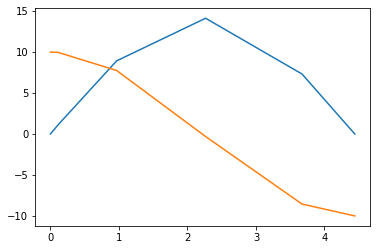

In [81]:
plt.plot(sol.t,sol.y.T)